# ADF for inference.
Start with explaining the core sampling operations:
1. Convolution of gaussians.
2. Greater than operator.

### Numerical(quantised) convolution.
\begin{align}
Skill & \sim \mathcal{N}(Skill;\ \mu_s,\,\sigma_s) \\
Performance & \sim \mathcal{N}(Performance;\ Skill,\,\sigma_p) \\
\end{align}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [3]:
from scipy.stats import norm

In [26]:
s1 = norm(4, np.sqrt(9))

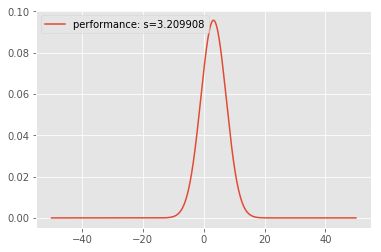

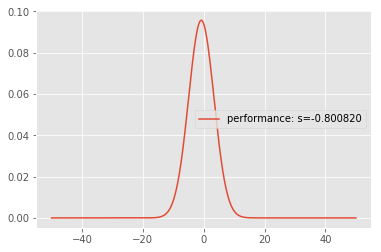

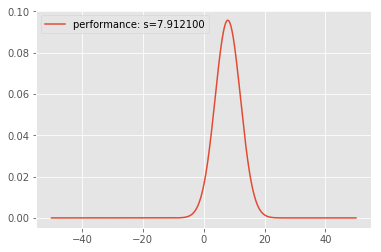

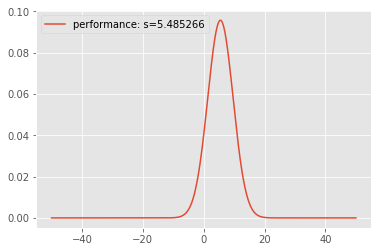

In [27]:
arr = []
for ix in range(100):    
    vs1 = s1.rvs()
    xs1 = np.linspace(-50, 50, 1000)
    
    p1 = norm(vs1, np.sqrt(17.361))
    vp1 = p1.rvs()
    xp1 = np.linspace(-50, 50, 1000)
    
    arr.append(p1.pdf(xp1))
    
    if ix%25==0:
        plt.figure()
        plt.plot(xp1, p1.pdf(xp1), label="performance: s=%f"%vs1)
        plt.legend()

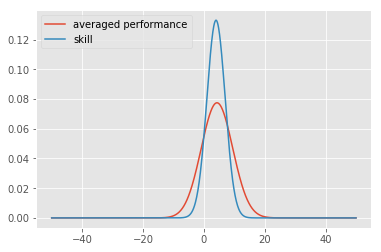

In [34]:
avg = np.mean(np.array(arr), axis=0)
plt.plot(xp1, avg, label="averaged performance")
plt.plot(xs1, s1.pdf(xs1), label="skill")
plt.legend()